In [59]:
import sys
sys.path.append('/home/ZhiLi/CRESTHH')
from cresthh.anuga import SWW_plotter
import numpy as np
import pandas as pd
%matplotlib inline
import geopandas as gpd
from cresthh.utils import flowAreaCalc as flow_area
from cresthh.utils import processSWW
from cresthh import metrics as met
from netCDF4 import Dataset
from glob import glob
from osgeo import gdal
from pyproj import Proj, CRS, transform

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [4]:
crossSection= gpd.read_file('/home/ZhiLi/CRESTHH/data/Harris/cross-section/crosssection.shp')

In [83]:
crossSection

,Value,geometry
0,15.220321,POINT (281573.248 3324578.999)
1,14.269851,POINT (281573.565 3324567.927)
2,4.676969,POINT (281573.881 3324556.856)
3,1.231332,POINT (281574.197 3324545.785)
4,3.370077,POINT (281574.514 3324534.714)
5,3.365883,POINT (281574.830 3324523.642)
6,3.362274,POINT (281575.146 3324512.571)
7,13.355147,POINT (281575.463 3324501.500)
8,13.351599,POINT (281575.779 3324490.428)


In [61]:
pnt= (-95.30338829750914, 30.031051379687135)
myProj = Proj("+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
print myProj(pnt[0],pnt[1])

(277882.6450409101, 3324461.3350396417)


In [136]:
splotter = SWW_plotter('/home/ZhiLi/CRESTHH/Examples/calibration/temp.sww', make_dir=False)

In [140]:
dr= pd.date_range('20170825000000', '20170825030000', freq='120S')

In [142]:
df= pd.DataFrame(index=dr)
df['sim']= splotter.stage[:,1000]

In [137]:
splotter.depth.shape

(91, 114868)

In [5]:
dr= pd.date_range('20170825000000','20170826000000', freq='120S')

In [130]:
OUTLET= (296751.22158,3292640.32167)
# OUTLET= (263713.9,3333272.7)

In [131]:
coupled= processSWW('Coupled_10m_modified_mesh.sww', ['depth','speed', 'soil moisture','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


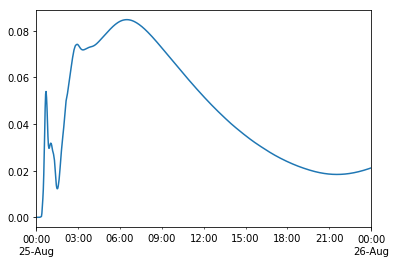

In [133]:
(coupled.speed*coupled.depth).plot()

In [66]:
noncoupled= processSWW('nonCoupled_10m_modified_mesh.sww', ['depth','speed', 'soil moisture','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


In [67]:
coupled_30m = processSWW('Coupled_30m_modified_mesh.sww', ['depth','speed', 'soil moisture','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


In [68]:
coupled_100m = processSWW('Coupled_100m_modified_mesh.sww', ['depth','speed', 'soil moisture','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


In [145]:
coupled['area']= coupled.apply(lambda x: flow_area(crossSection, x.stage), axis=1)
noncoupled['area']= noncoupled.apply(lambda x: flow_area(crossSection, x.stage), axis=1)
coupled_30m['area']= coupled_30m.apply(lambda x: flow_area(crossSection, x.stage), axis=1)
coupled_100m['area']= coupled_100m.apply(lambda x: flow_area(crossSection, x.stage), axis=1)

In [146]:
coupled['Q']= coupled.speed * coupled.area
noncoupled['Q']= noncoupled.speed * noncoupled.area
coupled_30m['Q']= coupled_30m.speed * coupled_30m.area
coupled_100m['Q']= coupled_100m.speed * coupled_100m.area

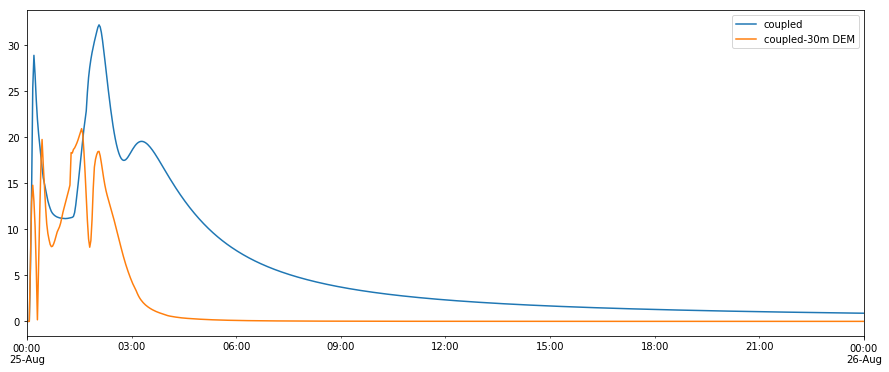

In [86]:
plt.figure(figsize=(15,6))
coupled.Q.plot(label='coupled')
# noncoupled.Q.plot(label='non-coupled')
coupled_30m.Q.plot(label='coupled-30m DEM')
# coupled_100m.speed.plot(label='coupled-100m DEM')
plt.legend();

In [22]:
first=True
for fname in glob('/home/ZhiLi/CRESTHH/data/synthetic_rainfall/*.tif'):
    if first:
        arr= gdal.Open(fname).ReadAsArray()/1000./3600.
        first=False
    else:
        arr+= gdal.Open(fname).ReadAsArray()/1000./3600.

In [12]:
xc= splotter.xc+ splotter.xllcorner
yc= splotter.yc+ splotter.yllcorner
iloc= np.argmin( (xc-OUTLET[0])**2 + (yc-OUTLET[1])**2 )

In [122]:
splotter= SWW_plotter('nonCoupled_10m_modified_mesh.sww', start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


In [12]:
xc= splotter.xc+ splotter.xllcorner
yc= splotter.yc+ splotter.yllcorner
iloc= np.argmin( (xc-OUTLET[0])**2 + (yc-OUTLET[1])**2 )

In [13]:
river= gpd.read_file('/home/ZhiLi/CRESTHH/data/HoustonCase/longest_reach/longest_reach.shp')

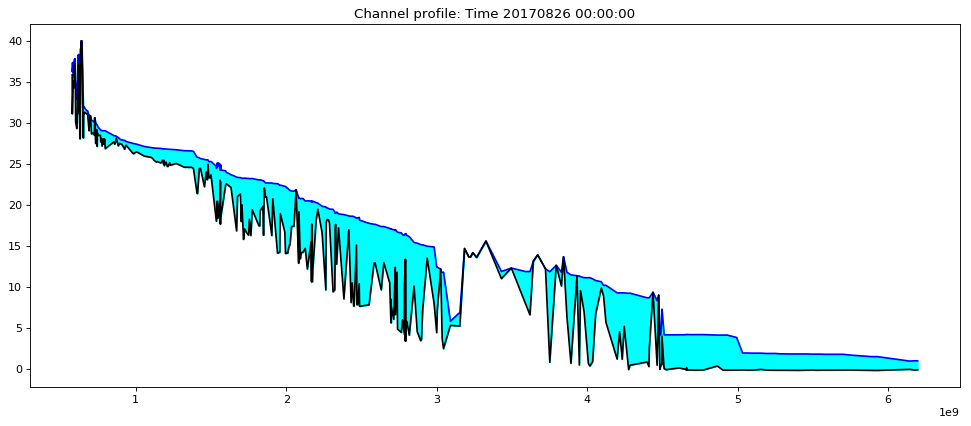

In [32]:
splotter.plot_longitudinal_frame(np.array(river.geometry[0]),frame=-1)

In [137]:
for i, time in enumerate(splotter.time):
#     print time
    if i>100:
        pass
    else:
#         splotter.save_depth_frame(frame=i, cmap='Blues', vmin=0, vmax=10, dpi=80)
        splotter.save_longitudinal_frame(np.array(river.geometry[0]), frame=i,  dpi=80)

<Figure size 1440x1008 with 0 Axes>

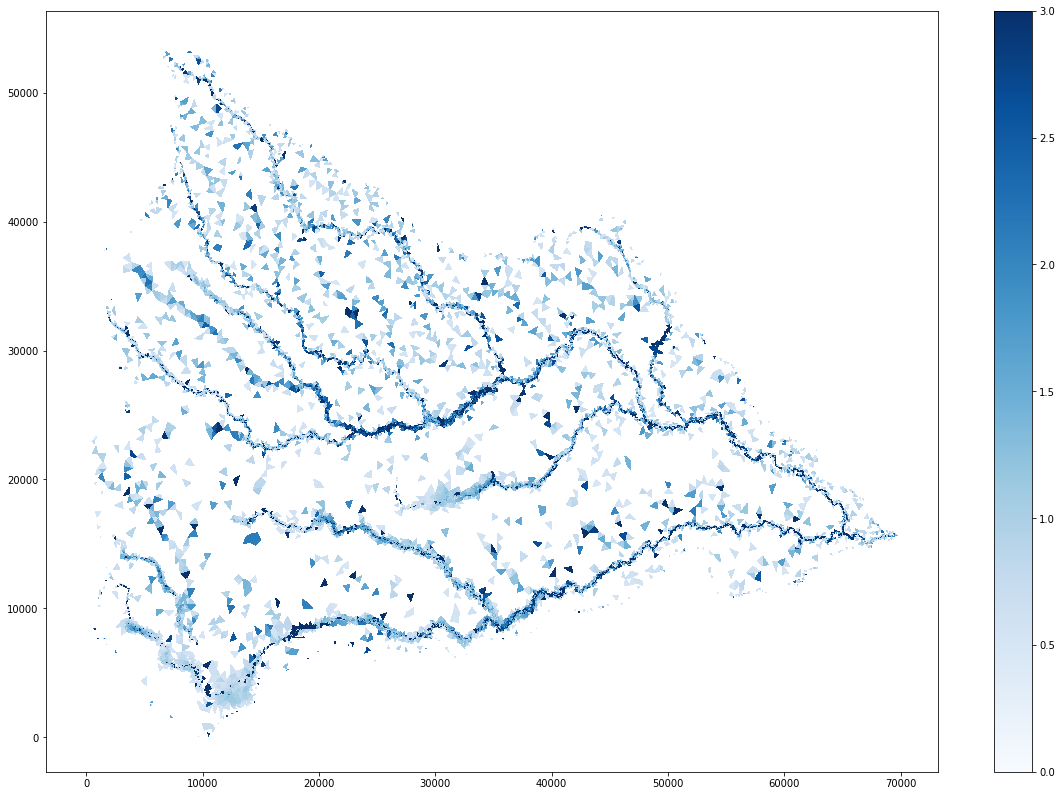

In [123]:
plt.figure(figsize=(20,14))
splotter.triang.set_mask(splotter.depth.max(axis=0) > .5)
# plt.tripcolor(splotter.triang,
#               facecolors=splotter.elev,
#               cmap='gray')
splotter.triang.set_mask(splotter.depth.max(axis=0) < .5)
plt.tripcolor(splotter.triang, 
              facecolors=(splotter.depth).max(axis=0),
              cmap='Blues',
             vmin=0,
             vmax=3)
plt.colorbar()

In [37]:
print splotter.xc[59535]+splotter.xllcorner, splotter.yc[59535]+splotter.yllcorner

269388.421691293 3330435.139551725


In [36]:
np.argmax((splotter.speed).max(axis=0))

59535

<Figure size 1440x864 with 0 Axes>

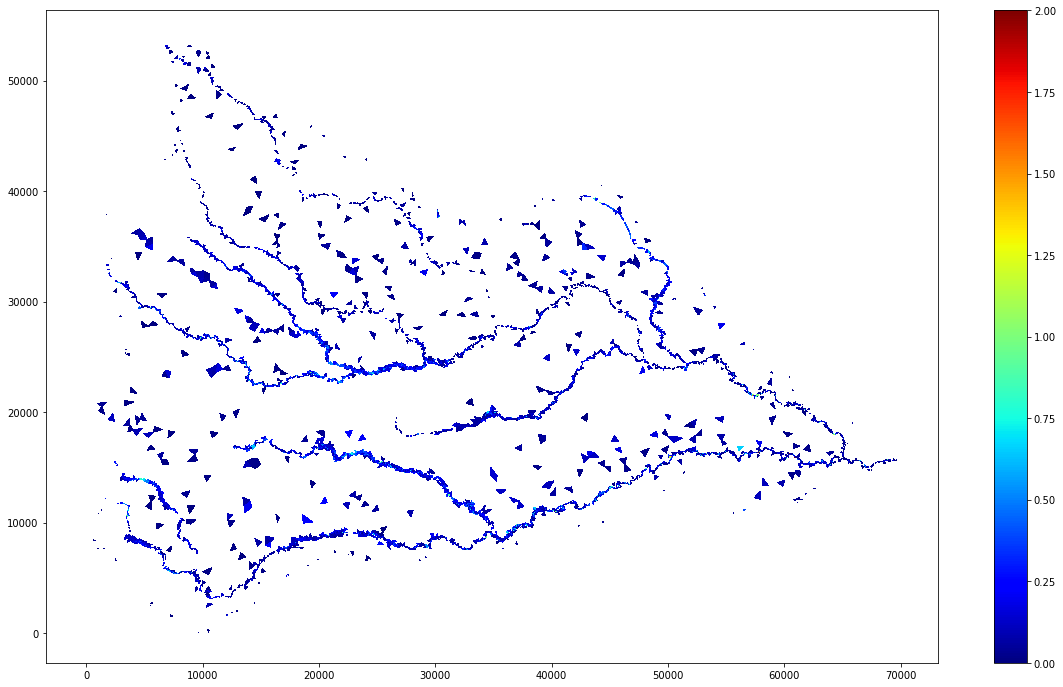

In [109]:
plt.figure(figsize=(20,12))
splotter.triang.set_mask(splotter.depth.max(axis=0) > 1)
# plt.tripcolor(splotter.triang,
#               facecolors=splotter.elev,
#               cmap='viridis')
splotter.triang.set_mask(splotter.depth.max(axis=0) <=1)
plt.tripcolor(splotter.triang, 
              facecolors=(splotter.speed).max(axis=0),
              cmap='jet',
             vmin=0,
             vmax=2)
plt.colorbar()

In [121]:
nc= Dataset('nonCoupled_10m_modified_mesh.sww')

In [110]:
new_nc= Dataset('ext_sensitivity.sww', 'w')

In [111]:
def createVariables(new_nc, nc, group='10m_coupled'):
    new_nc.createGroup(group)
    new_nc[group].createDimension('num_time', nc.dimensions['number_of_timesteps'].size)
    new_nc[group].createDimension('num_volumes', nc.dimensions['number_of_volumes'].size)
    new_nc[group].createDimension('num_vertices', nc.dimensions['number_of_vertices'].size)
    new_nc[group].createDimension('num_points', nc.dimensions['number_of_points'].size)
    new_nc[group].createVariable('time', nc['time'].dtype, ('num_time'))
    new_nc[group].createVariable('x', nc['x'].dtype, ('num_points'))
    new_nc[group].createVariable('y', nc['y'].dtype, ('num_points'))
    new_nc[group].createVariable('volumes', nc['volumes'].dtype, ('num_volumes', 'num_vertices'))
    new_nc[group].createVariable('depth', nc['stage_c'].dtype, ('num_time', 'num_volumes'))
    new_nc[group].createVariable('speed', nc['xmomentum_c'].dtype, ('num_time', 'num_volumes'))
    new_nc[group].createVariable('SM', nc['xmomentum_c'].dtype, ('num_time', 'num_volumes'))
    new_nc[group].createVariable('triangles', nc['xmomentum_c'].dtype, ('num_volumes', 'num_vertices'))
    new_nc[group+'/time'][:]= nc['time'][:]
    new_nc[group+'/x'][:]= nc['x'][:]
    new_nc[group+'/y'][:]= nc['y'][:]
    new_nc[group+'/volumes'][:]= nc['volumes'][:]
    new_nc[group+'/depth'][:]= nc['stage_c'][:] - nc['elevation_c'][:]
    new_nc[group+'/speed'][:]= (nc['xmomentum_c'][:]**2 + nc['ymomentum_c'][:]**2)**.5
    new_nc[group+'/SM'][:] = nc['SM_c'][:]
    new_nc[group].xllcorner= nc.xllcorner
    new_nc[group].yllcorner= nc.yllcorner
    
# new_nc.createGroup('10m_uncoupled')
# new_nc.createGroup('30m_coupled')
# new_nc.createGroup('100m_coupled')

In [122]:
createVariables(new_nc,nc,'10m_coupled')

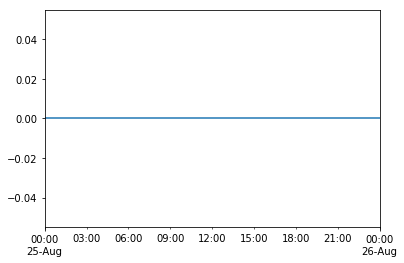

In [150]:
coupled.Q.plot()

In [154]:
coupled.Q.sum()

0.0

In [124]:
new_nc.close()